In [ ]:
# for Google Colab with T4 GPU backend
#!pip install ncon-torch
#!pip install scienceplots

In [13]:
import numpy as np
import torch, time, math
from ncon_torch import ncon
from scipy.optimize import approx_fprime
from scipy.stats import linregress
from tqdm import tqdm
import matplotlib.pyplot as plt
import scienceplots

In [6]:
def gpu_benchmark(n, device, num_instances=10):
  num_qubits = n
  local_dim = 2

  np_times = []
  torch_times = []
  for _ in range(num_instances): 
    np_sv = np.random.rand(local_dim**num_qubits) + 1j * np.random.rand(local_dim**num_qubits)
    np_sv /= np.linalg.norm(np_sv)
    np_sv = np_sv.reshape([local_dim] * num_qubits)
    torch_sv = torch.tensor(np_sv, dtype=torch.complex64, device=device)

    gate_np = np.random.rand(4, 4) + 1j * np.random.rand(4, 4)
    gate_np /= np.linalg.norm(gate_np)
    gate_np = gate_np.reshape(2, 2, 2, 2)  # shape: [i', j', i, j] (bra, ket)
    gate_torch = torch.tensor(gate_np, dtype=torch.complex64, device=device)

    gate_inds = [-1, -2, 1, 2]
    state_inds = [1,2] + [-i for i in range(3, num_qubits+1)]

    start_np = time.time()
    result_np = ncon([gate_np, np_sv], [gate_inds, state_inds])
    end_np = time.time()

    start_torch = time.time()
    result_torch = ncon([gate_torch, torch_sv], [gate_inds, state_inds])
    if device == 'cuda':
        torch.cuda.synchronize()
    end_torch = time.time()

    np_times.append(end_np-start_np)
    torch_times.append(end_torch-start_torch)

    assert np.allclose(result_np, result_torch.cpu().numpy()), "Mismatch between NumPy and PyTorch results!"
  return np.mean(np_times), np.mean(torch_times)

def cost(left_tensors, right_tensors): 
    contractions = [ncon([l, r], [[1, 2], [2, 1]]) for l, r in zip(left_tensors, right_tensors)]
    return math.prod(contractions)

def flat_to_matrices(x, n_pairs=10):
    return [x[i*4:(i+1)*4].reshape(2, 2) for i in range(n_pairs)]

def cost_fn_flat(x, right_tensors):
    left_tensors = flat_to_matrices(x, len(right_tensors))
    contractions = [ncon([l, r], [[1, 2], [2, 1]]) for l, r in zip(left_tensors, right_tensors)]
    return float(np.prod([c.item() if hasattr(c, 'item') else c for c in contractions]))

def ad_benchmark(max_size=20):
    cost_times = []
    ad_times = []
    fd_times = []

    sizes = list(range(1, max_size + 1))
    for size in sizes:
        left_tensors = [torch.randn(2, 2, dtype=torch.float64, requires_grad=True) for _ in range(size)]
        right_tensors = [torch.randn(2, 2, dtype=torch.float64) for _ in range(size)]
        left_np = np.concatenate([t.detach().numpy().flatten() for t in left_tensors])
        right_np = [t.detach().numpy() for t in right_tensors]

        start_cost = time.time()
        cost_value_torch = cost(left_tensors, right_tensors)
        cost_time = time.time() - start_cost
        cost_times.append(cost_time)

        start_ad = time.time()
        cost_value_torch.backward()
        ad_time = time.time() - start_ad
        ad_times.append(ad_time)
        
        eps = 1e-6
        start_fd = time.time()
        approx_fprime(left_np, lambda x: cost_fn_flat(x, right_np), eps)
        fd_time = time.time() - start_fd
        fd_times.append(fd_time)

    return sizes, cost_times, ad_times, fd_times

def set_style():
    plt.style.use(['science', 'grid'])
    plt.rcParams['text.usetex'] = False
    plt.rcParams['image.cmap'] = 'cividis'
    
    plt.rcParams['axes.labelsize'] = 8
    plt.rcParams['xtick.labelsize'] = 8  
    plt.rcParams['ytick.labelsize'] = 8 
    plt.rcParams['legend.fontsize'] = 8
    plt.rcParams['axes.titlesize'] = 10
    
    plt.rcParams['lines.linewidth'] = 1.5
    plt.rcParams['savefig.dpi'] = 300
    plt.rcParams['figure.dpi'] = 300 
    
    plt.rcParams['axes.grid'] = True  
    plt.rcParams['axes.spines.top'] = True 
    plt.rcParams['axes.spines.right'] = True
    plt.rcParams['xtick.top'] = False  
    plt.rcParams['ytick.right'] = False
    plt.rcParams['axes.spines.left'] = True
    plt.rcParams['ytick.left'] = False

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

n_range = np.arange(2,28,2)
np_times = []
torch_times = []
for n in tqdm(n_range):
    np_time, torch_time = gpu_benchmark(n, device)
    np_times.append(np_time)
    torch_times.append(torch_time)

set_style()
colors = plt.cm.plasma(np.linspace(0.3,0.7,2))
fig, ax = plt.subplots(figsize=(3.2,2))
plt.plot(n_range[1:], np_times[1:], label='NumPy', marker='o', color=colors[0])
plt.plot(n_range[1:], torch_times[1:], label='PyTorch', marker='o', color=colors[1])
plt.xlabel('number of qubits')
plt.ylabel('time (s)')
plt.legend()
plt.yscale('log')
plt.savefig('gpu_benchmark.png', bbox_inches='tight')

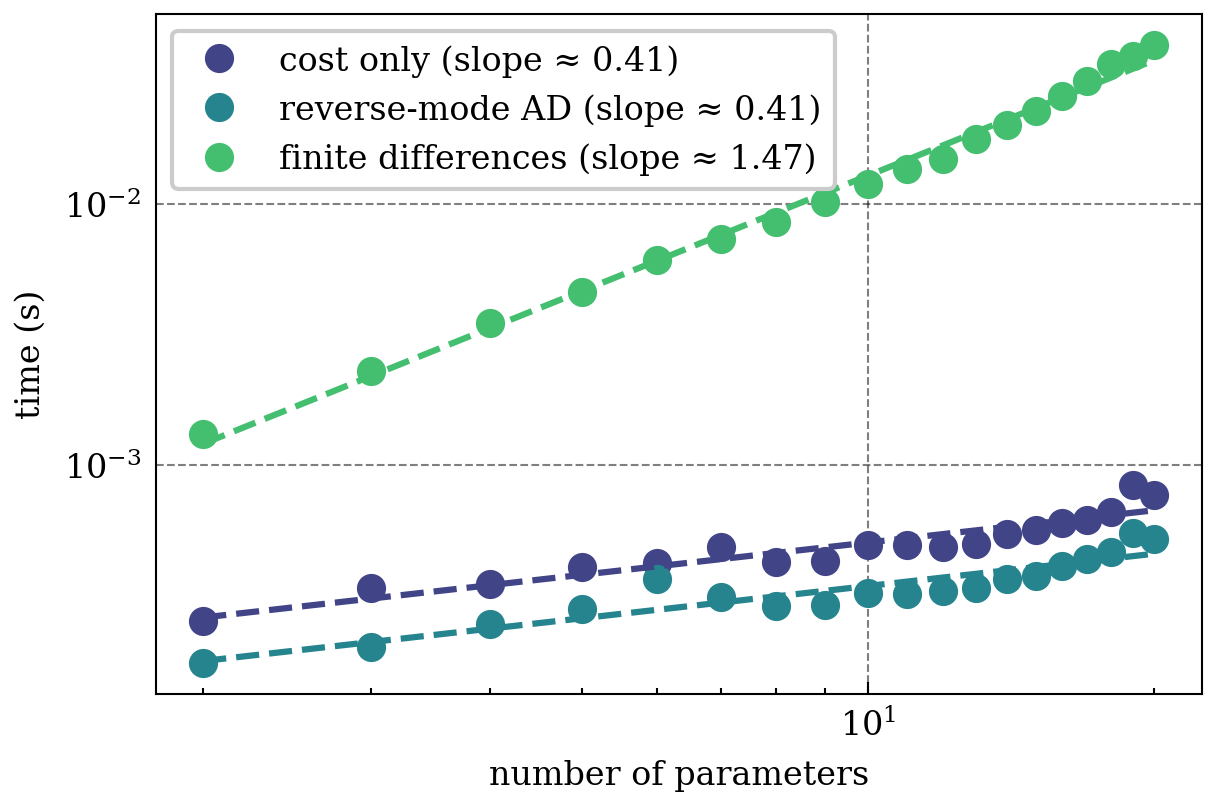

In [19]:
sizes, cost_times, ad_times, fd_times = ad_benchmark(max_size=20)
log_sizes = np.log10(sizes[1:])  
log_cost = np.log10(cost_times[1:])
log_ad = np.log10(ad_times[1:])
log_fd = np.log10(fd_times[1:])

slope_cost, intercept_cost, *_ = linregress(log_sizes, log_cost)
slope_ad, intercept_ad, *_ = linregress(log_sizes, log_ad)
slope_fd, intercept_fd, *_ = linregress(log_sizes, log_fd)

fit_cost = 10**(slope_cost * log_sizes + intercept_cost)
fit_ad = 10**(slope_ad * log_sizes + intercept_ad)
fit_fd = 10**(slope_fd * log_sizes + intercept_fd)

set_style()
colors = plt.cm.viridis(np.linspace(0.2, 0.7, 3))
fig, ax = plt.subplots(figsize=(4.5, 3))

ax.plot(sizes[1:], cost_times[1:], 'o', color=colors[0], label=f"cost only (slope ≈ {slope_cost:.2f})")
ax.plot(sizes[1:], ad_times[1:], 'o', color=colors[1], label=f"reverse-mode AD (slope ≈ {slope_ad:.2f})")
ax.plot(sizes[1:], fd_times[1:], 'o', color=colors[2], label=f"finite differences (slope ≈ {slope_fd:.2f})")

ax.plot(sizes[1:], fit_cost, '--', color=colors[0])
ax.plot(sizes[1:], fit_ad, '--', color=colors[1])
ax.plot(sizes[1:], fit_fd, '--', color=colors[2])

ax.set_xlabel('number of parameters')
ax.set_ylabel('time (s)')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
fig.patch.set_facecolor('white')
plt.savefig('ad_benchmark.png', bbox_inches='tight')